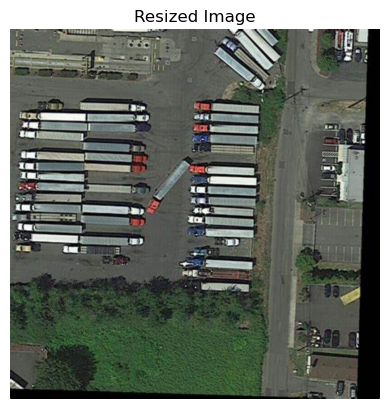

Number of masks generated: 529


In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def filter_masks(masks, threshold):
    filter_masks = []
    total = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        # filter
        total_value = np.sum(mask)
        percentage = total_value / total
        if percentage > threshold:
            continue
        filter_masks.append(mask_data)
    return filter_masks

## visual
def save_anns(image, anns, save_path):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.axis('off')
    plt.savefig(save_path)
    plt.close()

def write_masks_to_folder(image, masks, path, image_suffix, threshold=None):
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    # filter masks
    if threshold is not None:
        masks = filter_masks(masks, threshold)
    # save visual annotation fig
    save_anns(image, masks, os.path.join(path, 'full_mask'+image_suffix))
    # save each mask
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        filename = f"{i}"+image_suffix
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")
    with open(metadata_path, "w") as f:
        f.write("\n".join(metadata))
    return

sam_checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'
image_path = '/home/a6/vis/LDS/SAM/images/X2-E20m1-.png'

# create sam
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=device)
# sam_model.eval()
mask_generator = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.75,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(1024,1024))

# 使用 matplotlib 展示图像
plt.imshow(image)
plt.title('Resized Image')
plt.axis('off')  # 隐藏坐标轴
plt.show()

masks = mask_generator.generate(image)
print(f'Number of masks generated: {len(masks)}')

# specify the directory to save masks
masks_dir = '/home/a6/vis/LDS/SAM/masks'
os.makedirs(masks_dir, exist_ok=True)

# save masks to the specified directory
write_masks_to_folder(image, masks, masks_dir, '.png', threshold=0.3)

In [11]:
import json
import logging
import torch.nn.functional as F
import torch

# 创建 logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

output_dir = '/home/a6/vis/LDS/SAM/outputs'
mask_vec_npy_dir = os.path.join(output_dir, 'npy_masks')
json_mask_avg_vec_save_path = os.path.join(output_dir, 'json_masks')
# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_vec_npy_dir, exist_ok=True)
os.makedirs(json_mask_avg_vec_save_path, exist_ok=True)

image_torch = torch.as_tensor(image, device=device)
transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = sam_model.preprocess(transformed_image)
with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)  # [B, C, H, W]
b, c, h, w = image_embedding.shape

# Process each mask
masked_feature_list = {}
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]
mask_vecs = []
for mask_file in mask_files:
    mask_path = os.path.join(masks_dir, mask_file)
    mask_name = os.path.splitext(mask_file)[0]
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]
    mask = torch.as_tensor(mask, device=device)[None, None, :, :]  # [1, 1, H, W]
    
    # Rescale features and mask
    rescale_factor = 4  # 4x upsample/downsample
    t1, t2 = int(mask.shape[2] / rescale_factor), int(mask.shape[3] / rescale_factor)
    features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
    mask_rescale = F.interpolate(mask, size=[t1, t2], mode='bilinear')

    masked_feature = torch.mul(features_rescale, mask_rescale)
    masked_feature = masked_feature.view(b, c, -1)
    non_zero_count = torch.count_nonzero(masked_feature, dim=2)
    
    # Calculate average vector for mask
    masked_avg_vec = masked_feature.sum(dim=2) / non_zero_count
    masked_avg_vec[torch.isnan(masked_avg_vec)] = 0
    
    # Save masked feature vector
    npy_data = masked_avg_vec.detach().cpu().numpy()
    single_mask_vec_path = os.path.join(mask_vec_npy_dir, mask_name + '.npy')
    np.save(single_mask_vec_path, npy_data)
    masked_feature_list[mask_name] = single_mask_vec_path
    mask_vecs.append(npy_data)

# Save image and mask info to JSON
img_info = {
    'image_name': os.path.basename(image_path),
    'mask_avg_vec': masked_feature_list
}
json_save_name = os.path.join(json_mask_avg_vec_save_path, os.path.splitext(os.path.basename(image_path))[0] + '_mask_vec.json')
with open(json_save_name, "w") as file:
    json.dump(img_info, file)

logger.info(f'Saving image: {os.path.basename(image_path)} all masks as {json_save_name}.')



Filtered indices: [  1   3  10  11  15  17  20  29  39  46  47  48  54  61  64  75  80  85
  87  89  94 101 109 113 125 138 139 142 151 163 164 168 174 176 183 184
 185 194 199 204 211 227 236 238 240 258 267 282 290 291 292 328 342 350
 358 360 382 384 387 389 391 399 402 415 430 436 440 441 443 454 463 464
 480 484 485 488 491 494 496 505 511 522 525]
Filtered similarities: [0.9603343  0.78124535 0.7652666  0.734001   0.7828753  0.7194588
 0.7135606  0.7262295  0.7561885  0.7871184  0.76322234 0.86566746
 0.8428364  0.7521584  0.79869485 0.73539984 0.7642425  0.7080691
 0.7429661  1.0000002  0.73985076 0.81117105 0.89704156 0.70489347
 0.72351986 0.8104427  0.73282194 0.79657316 0.87984    0.7922487
 0.7350862  0.77072585 0.8038937  0.762609   0.705102   0.81160283
 0.7473548  0.73951006 0.81100756 0.75991577 0.77481556 0.76019907
 0.81536376 0.8022673  0.7216819  0.7431675  0.70596653 0.72148144
 0.8836981  0.74020445 0.7039106  0.7603245  0.71177626 0.8529993
 0.77877855 0.75327957

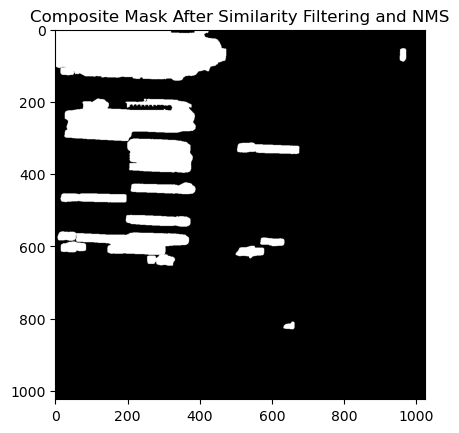

In [18]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定查询的文件名
query_file_name = "523.npy"  # 替换为你要查询的文件名
if query_file_name in file_names:
    query_index = file_names.index(query_file_name)
    query_feature = features[query_index]
else:
    raise ValueError(f"File {query_file_name} not found in the directory.")

# 计算相似性
similarities = cosine_similarity([query_feature], features)[0]

# 设定查询阈值
threshold = 0.7

# 找到相似度大于阈值的特征向量
filtered_indices = np.where(similarities > threshold)[0]
filtered_similarities = similarities[filtered_indices]

print(f"Filtered indices: {filtered_indices}")
print(f"Filtered similarities: {filtered_similarities}")

# 生成边界框并应用NMS
bboxes = []
scores = []

for idx in filtered_indices:
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        continue
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bboxes.append([x_min, y_min, x_max, y_max])
    scores.append(similarities[idx])  # Use the correct similarity for NMS

# 转换为张量
bboxes = torch.tensor(bboxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)

# 应用非极大抑制
nms_indices = nms(bboxes, scores, iou_threshold=0.3)

# 打印最终保留下来的掩码信息
print("Kept masks after similarity filtering and NMS:")
for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    print(f"File: {mask_name}")

# 绘制复合掩码图像
image_shape = (1024, 1024)  # Assuming all masks are of this shape
composite_image = np.zeros(image_shape, dtype=np.float32)

for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    composite_image = np.maximum(composite_image, mask)

# 绘制复合掩码图像
plt.imshow(composite_image, cmap='gray')
plt.title('Composite Mask After Similarity Filtering and NMS')
plt.show()


Cluster containing 523.npy: 286 masks
Filtered masks before NMS:
File: 118.png
File: 225.png
File: 174.png
File: 131.png
File: 389.png
File: 326.png
File: 448.png
File: 182.png
File: 157.png
File: 159.png
File: 453.png
File: 180.png
File: 190.png
File: 478.png
File: 396.png
File: 155.png
File: 480.png
File: 137.png
File: 523.png
File: 173.png
File: 108.png
File: 222.png
File: 133.png
File: 503.png
File: 521.png
File: 368.png
File: 223.png
File: 122.png
File: 406.png
File: 280.png
File: 227.png
File: 482.png
File: 214.png
File: 498.png
File: 178.png
File: 209.png
File: 276.png
File: 481.png
File: 177.png
File: 168.png
File: 325.png
File: 372.png
File: 199.png
File: 526.png
File: 169.png
File: 442.png
File: 234.png
File: 450.png
File: 500.png
File: 102.png
File: 496.png
File: 497.png
File: 99.png
File: 517.png
File: 120.png
File: 314.png
File: 220.png
File: 376.png
File: 103.png
File: 112.png
File: 492.png
File: 175.png
File: 200.png
File: 115.png
File: 167.png
File: 388.png
File: 513.pn

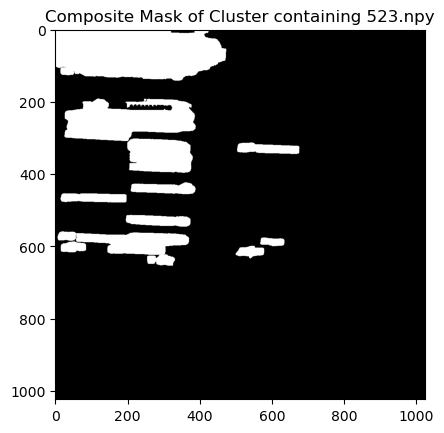

In [21]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定两个聚类中心的文件名
center_file_1 = "523.npy"  # 替换为你要作为聚类中心的文件名
center_file_2 = "62.npy"  # 替换为你要作为聚类中心的文件名

# 获取聚类中心的特征
if center_file_1 in file_names and center_file_2 in file_names:
    center_feature_1 = features[file_names.index(center_file_1)]
    center_feature_2 = features[file_names.index(center_file_2)]
else:
    raise ValueError("One or both center files not found in the directory.")

# 使用KMeans进行二分类，指定初始聚类中心
initial_centers = np.array([center_feature_1, center_feature_2])
kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)
labels = kmeans.fit_predict(features)

# 找到包含center_file_1的聚类结果
cluster_id_1 = labels[file_names.index(center_file_1)]
cluster_indices_1 = np.where(labels == cluster_id_1)[0]
print(f"Cluster containing {center_file_1}: {len(cluster_indices_1)} masks")

# 对聚类结果进行相似度查询，仅保留相似度大于0.7的掩码
filtered_indices = []
filtered_similarities = []
for idx in cluster_indices_1:
    similarity = cosine_similarity([features[idx]], [center_feature_1])[0][0]
    if similarity > 0.7:
        filtered_indices.append(idx)
        filtered_similarities.append(similarity)

# 生成边界框并打印过滤前的掩码信息
print("Filtered masks before NMS:")
bboxes = []
scores = []
for idx, similarity in zip(filtered_indices, filtered_similarities):
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    print(f"File: {mask_name}")
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        continue
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bboxes.append([x_min, y_min, x_max, y_max])
    scores.append(similarity)  # Use the correct similarity for NMS

# 转换为张量
bboxes = torch.tensor(bboxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)

# 应用非极大抑制
nms_indices = nms(bboxes, scores, iou_threshold=0.3)

# 打印被去除的掩码信息
removed_indices = set(filtered_indices) - set(filtered_indices[idx] for idx in nms_indices)
print("Removed masks by NMS:")
for idx in removed_indices:
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    print(f"File: {mask_name}")

# 打印最终保留下来的掩码信息
print(f"Kept masks in Cluster containing {center_file_1} after similarity filtering and NMS:")
for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    print(f"File: {mask_name}")

# 绘制复合掩码图像
image_shape = (1024, 1024)  # Assuming all masks are of this shape
composite_image = np.zeros(image_shape, dtype=np.float32)

for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    composite_image = np.maximum(composite_image, mask)

# 绘制复合掩码图像
plt.imshow(composite_image, cmap='gray')
plt.title(f'Composite Mask of Cluster containing {center_file_1}')
plt.show()
